In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
folder_path = '/content/drive/MyDrive/EU_Green/Catalonia'
os.chdir(folder_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [ ]:
import os
import pickle
import requests
from zipfile import ZipFile
from tqdm import tqdm
import warnings
from scipy.stats import mstats
from scipy import stats
warnings.filterwarnings("ignore")
import json
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import gc
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
df = pd.read_csv('small_model_prepared.csv')


### Model

In [ ]:


def model_pipeline(model_type, df , target, cross_val=False, grid_search=False, transform=False):

  if target not in df.columns:
      raise ValueError("DataFrame must contain a target column as the dependent variable.")
  if transform:
    df[target] = df[target].apply(lambda x: x if x >= 0 else 0)
    original_target = df[target]

    df[target], boxcox_lambda = stats.boxcox(df[target] + 1)
    lower_percentile = np.percentile(df[target], 1)
    upper_percentile = np.percentile(df[target], 99)
    df[target] = np.clip(df[target], lower_percentile, upper_percentile)
    scaler = StandardScaler()
    df[target] = scaler.fit_transform(df[[target]])


  X = df.drop(target, axis=1)
  y = df[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  if transform:
    y_test_original = original_target.loc[y_test.index]
    print('y_test_original', y_test_original.shape )
  else:
    y_test_original = y_test
  X_grid, temp1, y_grid, temp2 = train_test_split(X_train, y_train, test_size=0.8, random_state=42)
  # Define model and parameter grid based on selected model type
  if model_type.lower() == 'random_forest':
      model = RandomForestRegressor(n_estimators=100,
                                    random_state=42,
                                    max_depth=None,
                                    max_features= 0.5,
                                    min_samples_leaf=3,
                                    min_samples_split =2
                                    )
      param_grid = {
          'n_estimators': [100],
          'max_depth': [None,2, 4 ],
          'min_samples_split': [2, 4,],
          'min_samples_leaf': [1, 3,],
          'max_features': ['auto', 'sqrt', 0.5, 0.75, 1.0]
      }
  elif model_type.lower() == 'xgboost':
      model = XGBRegressor(n_estimators=100,
                           random_state=42,
                           use_label_encoder=False,
                           eval_metric='rmse',
                           gamma = 0,
                           learning_rate = 0.1,
                           max_depth = 4,
                           subsample = 1.0
                           )
      param_grid = {
          'n_estimators': [100,],
          'max_depth': [2,4],
          'learning_rate': [0.01, 0.1],
          'gamma': [0,  1.0],
          'subsample': [0.5,  1.0],

      }
  elif model_type.lower() == 'catboost':
      model = CatBoostRegressor(iterations=300,
                                random_seed=42,
                                verbose=0,
                                border_count = 64,
                                depth = 5,
                                l2_leaf_reg=0,
                                learning_rate=0.1
                                )
      param_grid = {
           'iterations': [100, 300,],
            'depth': [3, 5, ],
            'learning_rate': [0.01, 0.1],
            'l2_leaf_reg': [0, 0.5, 1.0],
            'border_count': [32, 64],
      }
  else:
      raise ValueError("Unsupported model_type. Choose from 'random_forest', 'xgboost', 'catboost'.")

  # If grid_search flag is True, perform grid search hyperparameter tuning using 5-fold CV.
  if grid_search:
      print("Starting grid search for hyperparameter tuning...")
      print('data for grid search: ',X_grid.shape)
      grid = GridSearchCV(estimator=model, param_grid=param_grid,
                          cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
      grid.fit(X_grid, y_grid)
      print("Best parameters from Grid Search:", grid.best_params_)
      best_model = grid.best_estimator_
  else:
      best_model = model

  # If cross_val flag is True, perform 5-fold cross validation on the selected model.
  if cross_val:
      print("Performing 5-fold cross-validation...")
      cv_scores = cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
      print("Cross Validation Scores (neg MSE):", cv_scores)
      print("Mean CV Score (neg MSE):", cv_scores.mean())

  # Train the final model on the full dataset
  print("training the model ...")

  best_model.fit(X_train, y_train)

  print("Model training is complete.")

  # Extract and plot feature importance if available
  if hasattr(best_model, "feature_importances_"):
      importances = best_model.feature_importances_
      imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
      imp_df = imp_df.sort_values(by='importance', ascending=False)
      print("Feature Importances:")
      print(imp_df)
      imp_df.plot(kind='bar', x='feature', y='importance', figsize=(8,6),
                  title="Feature Importances")
      plt.ylabel("Importance")
      plt.tight_layout()
      plt.show()
  else:
      print("The selected model does not support a 'feature_importances_' attribute.")
  # ---------------------------- Prediction & Inversion ---------------------------- #
  print('prediction part ...')
  if transform:
    y_pred_scaled = best_model.predict(X_test).reshape(-1, 1)
    y_pred_boxcox = scaler.inverse_transform(y_pred_scaled)
    y_pred_original = inv_boxcox(y_pred_boxcox, boxcox_lambda) - 1
  else:
    y_pred_original = best_model.predict(X_test)

  print("Number of NaN values in predictions before dropping:", np.count_nonzero(np.isnan(y_pred_original)))
  mask = ~np.isnan(y_pred_original)
  y_pred_clean = y_pred_original[mask]
  mask = ~np.isnan(y_pred_original).flatten()
  y_test_clean = y_test_original[mask]
  print("Number of NaN values in predictions after dropping:", np.count_nonzero(np.isnan(y_pred_clean)))
  print('len test:', len(y_test_clean))
  mse = mean_squared_error(y_test_clean, y_pred_clean)
  mae = mean_absolute_error(y_test_clean, y_pred_clean)
  r2 = r2_score(y_test_clean, y_pred_clean)

  print("Mean Squared Error:", mse)
  print("Mean Absolute Error:", mae)
  print("R² Score:", r2)
  # --------------------------------------------------------------------------------- #
  # Return the fitted (best) model in case further analysis or predictions are needed.
  return best_model , X_test, y_test



### Feature Selection

In [ ]:
correlations1 = df.corr()['preprocessed_Emissions de CO2' ]
selected_cols = correlations1[abs(correlations1) > 0.15].index.tolist()
data = df[selected_cols]
selected_cols

['pp_total_energy',
 'pp_total_Emissions',
 'heating_efficiency',
 'Energia primària no renovable',
 'Emissions de CO2',
 "Consum d'energia final",
 "preprocessed_Cost anual aproximat d'energia per habitatge",
 'preprocessed_Energia primària no renovable',
 'preprocessed_Emissions de CO2',
 "preprocessed_Consum d'energia final",
 'preprocessed_VALOR AILLAMENTS',
 'preprocessed_Energia calefacció demanda',
 'preprocessed_heating_efficiency',
 'preprocessed_Insulation Performance Index',
 "ENCODED Qualificació de consum d'energia primaria no renovable",
 "ENCODED Qualificacio d'emissions de CO2",
 'Tipus Tramit_Edificis acabats',
 'Tipus Tramit_Edificis existents',
 'FR_Encoded_Normativa construcció',
 'FR_Encoded_Motiu de la certificacio',
 'FR_Encoded_Eina de certificacio']

In [ ]:
selected_cols = ['pp_total_energy',
 'pp_total_Emissions',
 'heating_efficiency',
 'preprocessed_Energia primària no renovable',
 "preprocessed_Consum d'energia final",
 "preprocessed_Cost anual aproximat d'energia per habitatge",
 'preprocessed_VALOR AILLAMENTS',
 'preprocessed_Energia calefacció demanda',
 'preprocessed_heating_efficiency',
 'preprocessed_Insulation Performance Index',
 "ENCODED Qualificació de consum d'energia primaria no renovable",
 "ENCODED Qualificacio d'emissions de CO2",
 'Tipus Tramit_Edificis acabats',
 'Tipus Tramit_Edificis existents',
 'FR_Encoded_Normativa construcció',
 'FR_Encoded_Motiu de la certificacio',
  "Emissions de CO2",
  "preprocessed_Emissions de CO2",

 'FR_Encoded_Eina de certificacio']

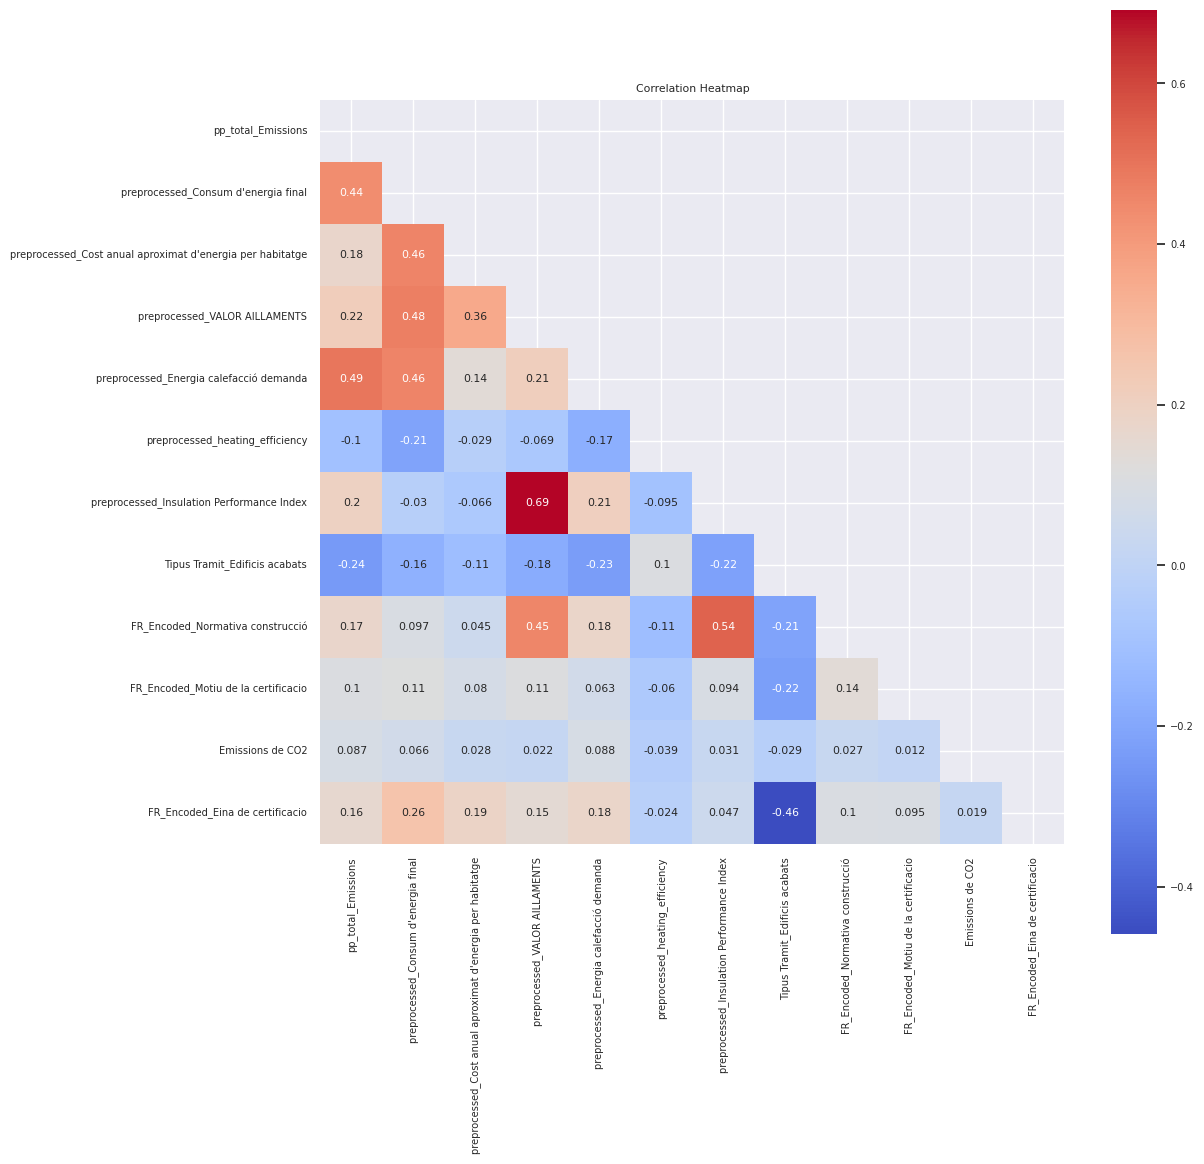

In [ ]:
data = df[selected_cols]
data = data.drop(columns=['pp_total_energy',
                           'heating_efficiency',
                          "preprocessed_Emissions de CO2",
                          'preprocessed_Energia primària no renovable',
                          "ENCODED Qualificacio d'emissions de CO2",
                           'Tipus Tramit_Edificis existents',
                          "ENCODED Qualificació de consum d'energia primaria no renovable",])
corr_matrix1 = data.corr()
matrix = np.triu(corr_matrix1)
plt.figure(figsize=(12, 12))
sns.set(font_scale=.65)
sns.heatmap(corr_matrix1,annot=True, cmap='coolwarm', square=True , mask =matrix )
plt.title("Correlation Heatmap")
plt.show()

### RandomForest
 {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

y_test_original (267385,)
training the model ...
Model training is complete.
Feature Importances:
                                              feature  importance
1                 preprocessed_Consum d'energia final    0.469803
4             preprocessed_Energia calefacció demanda    0.174281
0                                  pp_total_Emissions    0.123845
2   preprocessed_Cost anual aproximat d'energia pe...    0.110220
5                     preprocessed_heating_efficiency    0.067944
6           preprocessed_Insulation Performance Index    0.020284
3                       preprocessed_VALOR AILLAMENTS    0.017109
9                 FR_Encoded_Motiu de la certificacio    0.007806
8                    FR_Encoded_Normativa construcció    0.006421
10                    FR_Encoded_Eina de certificacio    0.002080
7                       Tipus Tramit_Edificis acabats    0.000208


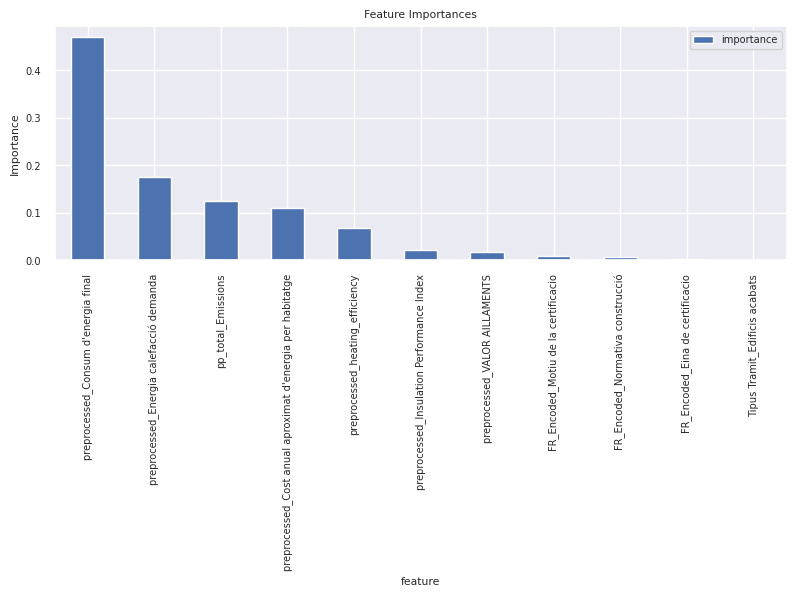

prediction part ...
Number of NaN values in predictions before dropping: 0
Number of NaN values in predictions after dropping: 0
len test: 267385
Mean Squared Error: 0.12089666632600303
Mean Absolute Error: 0.13737208872732026
R² Score: 0.7326848398995576


In [ ]:
rf_model , X_test, y_test = model_pipeline (model_type="random_forest",
                            df=data,
                            cross_val=False,
                            grid_search=False,
                            transform=True,
                            target ='Emissions de CO2' )

### Catboost
{'border_count': 64, 'depth': 5, 'iterations': 300, 'l2_leaf_reg': 0, 'learning_rate': 0.1}

y_test_original (267385,)
training the model ...
Model training is complete.
Feature Importances:
                                              feature  importance
1                 preprocessed_Consum d'energia final   45.796895
2   preprocessed_Cost anual aproximat d'energia pe...   13.101717
4             preprocessed_Energia calefacció demanda   13.100444
0                                  pp_total_Emissions   11.699416
5                     preprocessed_heating_efficiency    9.804266
3                       preprocessed_VALOR AILLAMENTS    2.318833
6           preprocessed_Insulation Performance Index    1.796363
9                 FR_Encoded_Motiu de la certificacio    1.091679
8                    FR_Encoded_Normativa construcció    0.649480
10                    FR_Encoded_Eina de certificacio    0.595096
7                       Tipus Tramit_Edificis acabats    0.045812


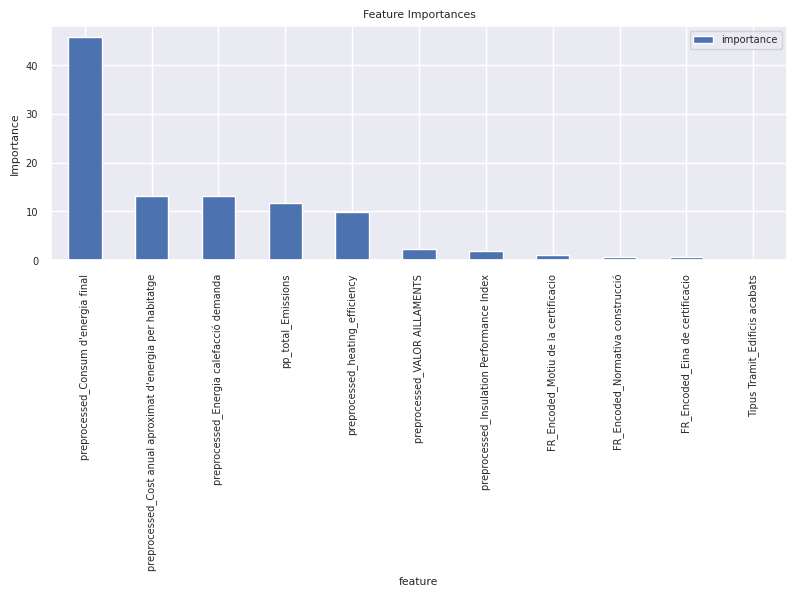

prediction part ...
Number of NaN values in predictions before dropping: 2194
Number of NaN values in predictions after dropping: 0
len test: 265191
Mean Squared Error: 0.8339671828430775
Mean Absolute Error: 0.026368806928338904
R² Score: 0.005326220137494286


In [ ]:
catboost_model , X_test, y_test = model_pipeline (model_type="catboost",
                            df=data,
                            cross_val=False,
                            grid_search=False,
                            transform=True,
                            target ='Emissions de CO2' )

### XGBoost
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}

y_test_original (267385,)
training the model ...
Model training is complete.
Feature Importances:
                                              feature  importance
1                 preprocessed_Consum d'energia final    0.485409
4             preprocessed_Energia calefacció demanda    0.128358
3                       preprocessed_VALOR AILLAMENTS    0.120179
0                                  pp_total_Emissions    0.108100
2   preprocessed_Cost anual aproximat d'energia pe...    0.049927
5                     preprocessed_heating_efficiency    0.035660
6           preprocessed_Insulation Performance Index    0.032125
8                    FR_Encoded_Normativa construcció    0.016184
10                    FR_Encoded_Eina de certificacio    0.009633
9                 FR_Encoded_Motiu de la certificacio    0.009622
7                       Tipus Tramit_Edificis acabats    0.004803


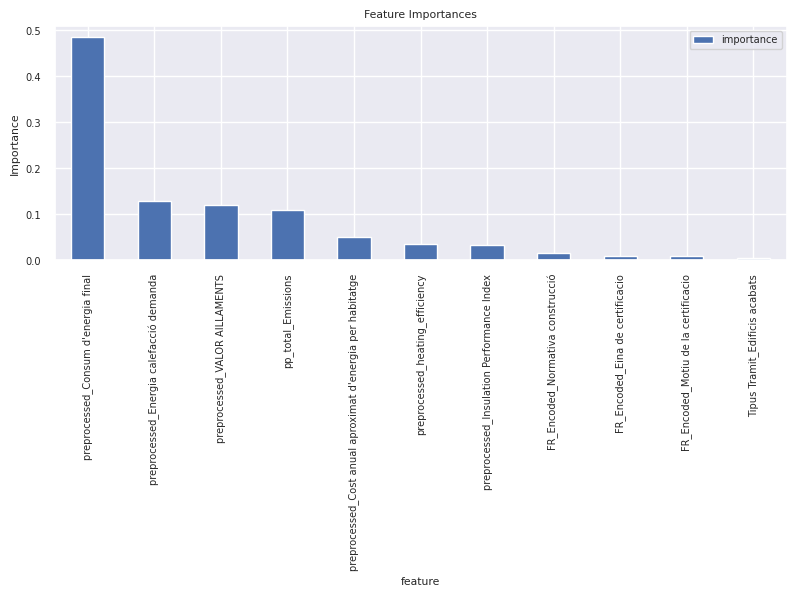

prediction part ...
Number of NaN values in predictions before dropping: 517
Number of NaN values in predictions after dropping: 0
len test: 266868
Mean Squared Error: 0.19522896904889783
Mean Absolute Error: 0.2029360631550762
R² Score: 0.5760531507314118


In [ ]:
xgb_model , X_test, y_test = model_pipeline (model_type="xgboost",
                            df=data,
                            cross_val=False,
                            grid_search=False,
                            transform=True,
                            target ='Emissions de CO2' )

### Ensemble

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
import numpy as np

target ='Emissions de CO2'
# ------------------transformation ------------------
data[target] = data[target].apply(lambda x: x if x >= 0 else 0)
original_target = data[target]

data[target], boxcox_lambda = stats.boxcox(data[target] + 1)
lower_percentile = np.percentile(data[target], 1)
upper_percentile = np.percentile(data[target], 99)
data[target] = np.clip(data[target], lower_percentile, upper_percentile)
scaler = StandardScaler()
data[target] = scaler.fit_transform(data[[target]])

# --------------------test train split ----------------------
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_original = original_target.loc[y_test.index]
print('y_test_original', y_test_original.shape )

# ---------------------- meta-regressor ---------------------
# (a simple and interpretable model is often chosen)
meta_reg = LinearRegression()

# Create a list of base estimators for stacking
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('catboost', catboost_model)
]


# Build the Stacking Regressor
stacking_ensemble = StackingRegressor(estimators=estimators, final_estimator=meta_reg)

# Train the stacking ensemble
stacking_ensemble.fit(X_train, y_train)

# Predict on test data
ensemble_predictions = stacking_ensemble.predict(X_test)

# -------------Inversion -----------------------
y_pred_scaled = ensemble_predictions.reshape(-1, 1)
y_pred_boxcox = scaler.inverse_transform(y_pred_scaled)
y_pred_original = inv_boxcox(y_pred_boxcox, boxcox_lambda) - 1

mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R² Score:", r2)

stacking_ensemble

y_test_original (267385,)
Mean Squared Error: 0.1195328046499827
Mean Absolute Error: 0.13751483559909694
R² Score: 0.7357004805566549


StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_features=0.5,
                                                     min_samples_leaf=3,
                                                     random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='rmse',
                                            feature_types=None, gamma...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x791822bfd690>)],
                  final_estimator=LinearRegression())

### Shap and Lime

In [ ]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

fig = shap.summary_plot(shap_values, X_test, show=False)
plt.gcf().set_size_inches(12, 8)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()
plt.show()

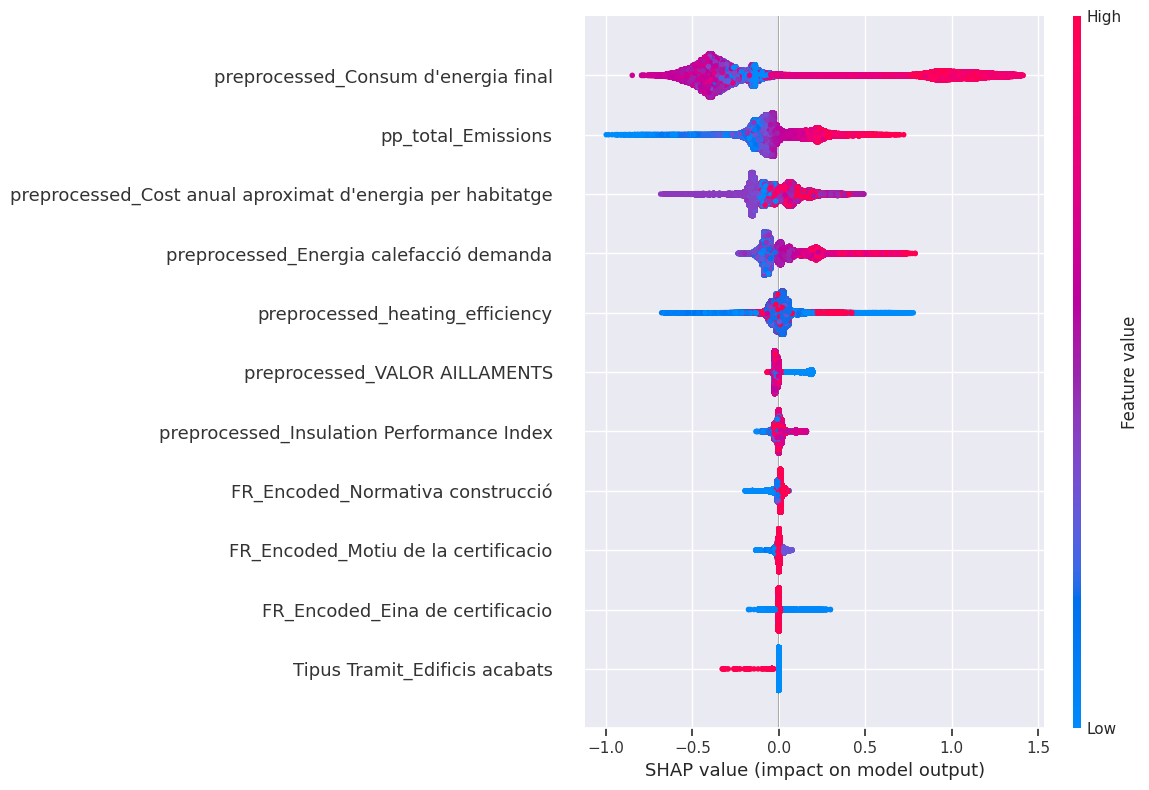

In [ ]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

fig = shap.summary_plot(shap_values, X_test, show=False)
plt.gcf().set_size_inches(12, 8)  # Example size: 12 inches wide, 8 inches tall

# Adjust the font size
plt.rcParams.update({'font.size': 10})  # Set font size to 8 points

# Show the plot
plt.tight_layout()  # Ensure labels fit within the figure area
plt.show()

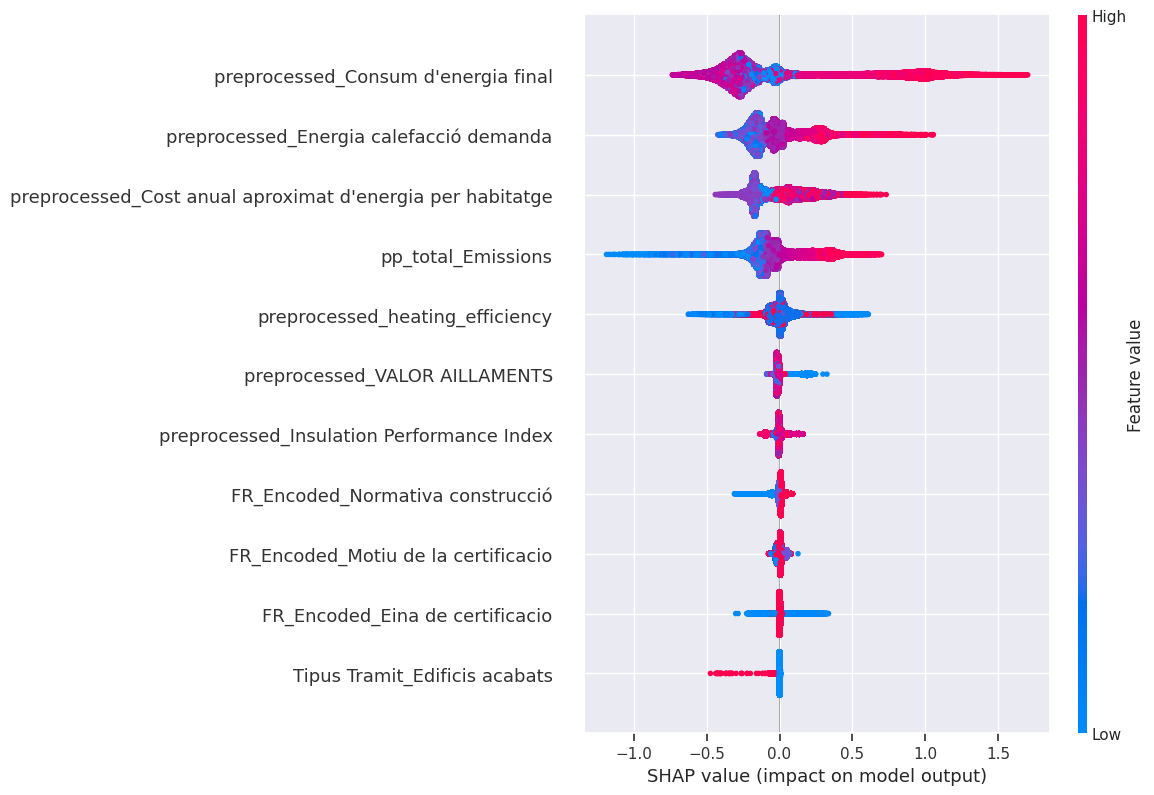

In [ ]:
import shap

explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)

fig = shap.summary_plot(shap_values, X_test, show=False)
plt.gcf().set_size_inches(12, 8)  # Example size: 12 inches wide, 8 inches tall

# Adjust the font size
plt.rcParams.update({'font.size': 10})  # Set font size to 8 points

# Show the plot
plt.tight_layout()  # Ensure labels fit within the figure area
plt.show()

Missing values in X_train: 0


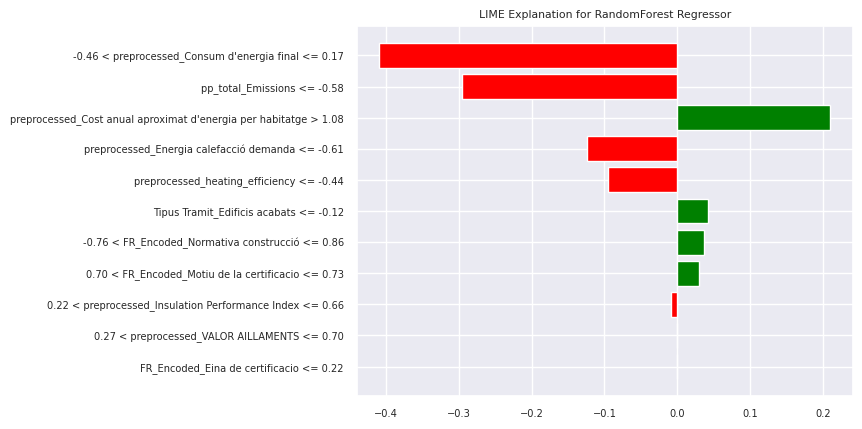

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from catboost import CatBoostRegressor
import lime.lime_tabular

# Assuming 'data' is your DataFrame
target = 'Emissions de CO2'
X = data.drop(target, axis=1)
y = data[target]

# Check for missing values
print("Missing values in X_train:", X.isnull().sum().sum())

# Ensure no missing values
X.fillna(X.median(), inplace=True)  # Replace missing values with mean

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LIME explainer for regression tasks
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='regression',
    feature_names=X_train.columns,
    discretize_continuous=True,
    random_state=42
)

# Choose an instance to explain from the test set
instance = X_test.head(1)

# Explain the XGBoost Regressor prediction
explanation_xgb = explainer.explain_instance(
    data_row=instance.values[0],  # Pass a single row (1D array)
    predict_fn=lambda x: rf_model.predict(x),  # Use a lambda function for predict
    num_features=len(X_train.columns),
)

# Visualize the explanation for XGBoost
fig_xgb = explanation_xgb.as_pyplot_figure()
plt.title("LIME Explanation for RandomForest Regressor")
plt.show()


Missing values in X_train: 0


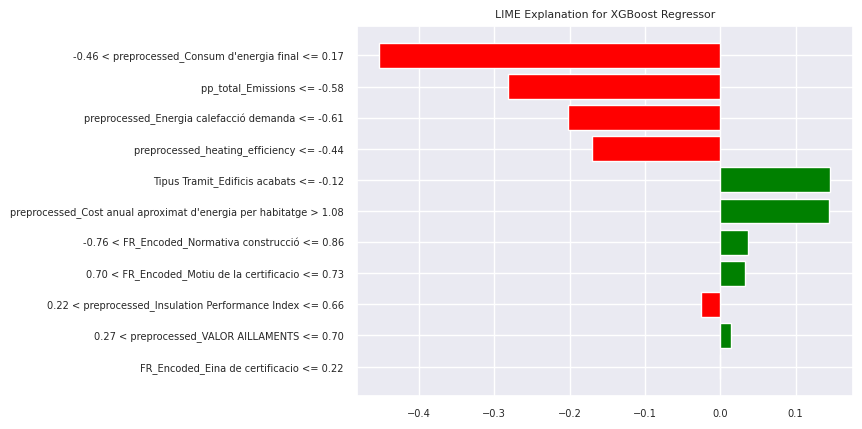

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from catboost import CatBoostRegressor
import lime.lime_tabular

# Assuming 'data' is your DataFrame
target = 'Emissions de CO2'
X = data.drop(target, axis=1)
y = data[target]

# Check for missing values
print("Missing values in X_train:", X.isnull().sum().sum())

# Ensure no missing values
X.fillna(X.median(), inplace=True)  # Replace missing values with mean

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LIME explainer for regression tasks
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='regression',
    feature_names=X_train.columns,
    discretize_continuous=True,
    random_state=42
)

# Choose an instance to explain from the test set
instance = X_test.head(1)

# Explain the XGBoost Regressor prediction
explanation_xgb = explainer.explain_instance(
    data_row=instance.values[0],  # Pass a single row (1D array)
    predict_fn=lambda x: xgb_model.predict(x),  # Use a lambda function for predict
    num_features=len(X_train.columns),
)

# Visualize the explanation for XGBoost
fig_xgb = explanation_xgb.as_pyplot_figure()
plt.title("LIME Explanation for XGBoost Regressor")
plt.show()


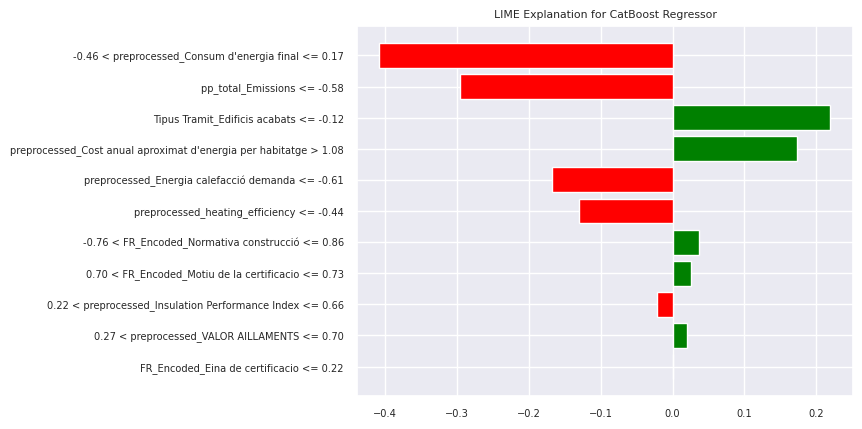

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from catboost import CatBoostRegressor
import lime.lime_tabular

# Assuming 'data' is your DataFrame
target = 'Emissions de CO2'
X = data.drop(target, axis=1)
y = data[target]

# Ensure no missing values
X.fillna(X.median(), inplace=True)  # Replace missing values with mean

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LIME explainer for regression tasks
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='regression',
    feature_names=X_train.columns,
    discretize_continuous=True,
    random_state=42
)

# Choose an instance to explain from the test set
instance = X_test.head(1)

# Explain the XGBoost Regressor prediction
explanation_xgb = explainer.explain_instance(
    data_row=instance.values[0],  # Pass a single row (1D array)
    predict_fn=lambda x: catboost_model.predict(x),  # Use a lambda function for predict
    num_features=len(X_train.columns),
)

# Visualize the explanation for XGBoost
fig_xgb = explanation_xgb.as_pyplot_figure()
plt.title("LIME Explanation for CatBoost Regressor")
plt.show()
